<a href="https://colab.research.google.com/github/dpatinoecheverri/ENV717_S23/blob/main/Assignments/A03/ENV717_A3_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 3
##ENV717- Spring 2023
---

Instructor: [Dalia Patino-Echeverri ](mailto:dalia.patino@duke.edu)

Author(s): [Mauricio Hernandez](mailto:mmh54@duke.edu)

[Github repository](https://github.com/dpatinoecheverri/ENV717_S23)

In this assignment, you will use eGrid and EIA data to create a supply curve for electricity in PJM, and PJM demand data to estimate cost of meeting different demand levels. 

In [ ]:
#import libraries
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

#Connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')
#save path
path = "/content/gdrive/MyDrive/ENV717-S2023/A03/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1. (25%) 
Download the file eGRID2020.xls from the eGRID website released on 1/27/2022, which contains the most recent data on power generation units for the U.S <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1).  Look at the PLNT20 tab and create a subset of power plants that contains only those plants with the following characteristics: 

- Column L, Balancing Authority Code, is PJM Interconnection, LLC.
- Column Y, Plant primary fuel category is equal to Coal, Gas, Hydro, or Nuclear. 
- Column AA, Plant capacity factor, is 0.1 or greater. 
- Column AB, Plant nameplate capacity (MW), is 10 or more. 

[1] 

<font size= "2"><a name="cite_note-1"></a>[1.](#cite_ref-1) The next release scheduled for 2023 will occur after this assignment is designed. </font>


In [ ]:
###############################################################################################################
## 1. Read eGRID20 file directly form EPA website
## Read the PLNT20 sheet of the excel file into a pandas DataFrame.
## A DataFrame is a two-dimensional labeled data structure with columns of potentially different types
## Specify that the headers are on the second row of the excel file (i.e., row 1 in Python)
## 2. Confirm we read all columns by printing the first five rows
###############################################################################################################
df_plnt = pd.read_excel("https://www.epa.gov/system/files/documents/2022-01/egrid2020_data.xlsx", 
                       sheet_name="PLNT20", keep_default_na=False, header=1)

#Name of columns
# 2. Select Columns that are needed for the analysis
# Balancing Authority Name: BANAME
# Plant primary fuel category: PLFUELCT
# Plant capacity factor: CAPFAC
# Plant nameplate capacity: NAMEPCAP

# These variables are needed for exercise 1b
# Plant annual heat input from combustion (MMBTU): PLHTIAN
# Plant annual net generation (MWh): PLNGENAN
# Plant annual CO2 equivalent emissions (tons): PLCO2EQA

# Also include name of plants
# Plant name: PNAME

# 3. Convert numeric columns to numeric, probably not necesary.
df_plnt.CAPFAC=pd.to_numeric(df_plnt.CAPFAC)
df_plnt.NAMEPCAP=pd.to_numeric(df_plnt.NAMEPCAP)
df_plnt.PLHTIAN=pd.to_numeric(df_plnt.PLHTIAN)
df_plnt.PLNGENAN=pd.to_numeric(df_plnt.PLNGENAN)
df_plnt.PLCO2EQA=pd.to_numeric(df_plnt.PLCO2EQA)

#Show first 5 plants
df_plnt.head(n=5)

,SEQPLT20,YEAR,PSTATABB,PNAME,ORISPL,OPRNAME,OPRCODE,UTLSRVNM,UTLSRVID,SECTOR,...,PLWIPR,PLSOPR,PLGTPR,PLOFPR,PLOPPR,PLTNPR,PLTRPR,PLTHPR,PLCYPR,PLCNPR
0,1,2020,AK,7-Mile Ridge Wind Project,60814,Alaska Power and Telephone Co,219,Alaska Power and Telephone Co,219,Electric Utility,...,,,,,,,,,,
1,2,2020,AK,Agrium Kenai Nitrogen Operations,54452,Homer Electric Assn Inc,19558,Agrium US Inc,179,Industrial CHP,...,,,,,,,,,,
2,3,2020,AK,Alakanuk,57053,"Alaska Village Elec Coop, Inc",221,"Alaska Village Elec Coop, Inc",221,Electric Utility,...,,,,,,,,,,
3,4,2020,AK,Allison Creek Hydro,58982,"Copper Valley Elec Assn, Inc",4329,"Copper Valley Elec Assn, Inc",4329,Electric Utility,...,0,0,0,0,0,0,1,0,0,1
4,5,2020,AK,Ambler,60243,"Alaska Village Elec Coop, Inc",221,"Alaska Village Elec Coop, Inc",221,Electric Utility,...,0,0,0,0,0,1,0,0,1,0


In [ ]:
#4. Create subset of plants
#Select only the attributes required, the copy function is recommended, the code 
# works without this function
df_plnt_sub = df_plnt.loc[:,['PNAME', 'BANAME', 'PLFUELCT', 'CAPFAC', 
                             'NAMEPCAP', 'PLHTIAN', 'PLNGENAN', 'PLCO2EQA']].copy()

#  Balancing Authority Code, is PJM Interconnection, LLC
BA_NAME = 'PJM Interconnection, LLC'
df_plnt_sub = df_plnt_sub.loc[df_plnt_sub.BANAME == BA_NAME]

#Plant primary fuel category is equal to Coal, Gas, Hydro, or Nuclear
df_plnt_sub = df_plnt_sub.loc[(df_plnt_sub.PLFUELCT == 'COAL') | 
                              (df_plnt_sub.PLFUELCT == 'GAS') | 
                              (df_plnt_sub.PLFUELCT == 'HYDRO') | 
                              (df_plnt_sub.PLFUELCT == 'NUCLEAR')]

#Plant capacity factor, is 0.1 or greater.
df_plnt_sub = df_plnt_sub.loc[df_plnt_sub.CAPFAC >= 0.1]

#Plant nameplate capacity (MW), is 10 or more
df_plnt_sub = df_plnt_sub.loc[df_plnt_sub.NAMEPCAP >= 10]
df_plnt_sub

,PNAME,BANAME,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,PLCO2EQA
2682,GSA Central Heating,"PJM Interconnection, LLC",GAS,0.52325,10.8,6.143997e+05,49504.0,35934.288
2705,Garrison Energy Center,"PJM Interconnection, LLC",GAS,0.49953,361.0,1.107430e+07,1579697.0,659188.999
2714,Red Lion Energy Center,"PJM Interconnection, LLC",GAS,0.93491,25.0,NaN,204746.0,NaN
3815,Braidwood Generation Station,"PJM Interconnection, LLC",NUCLEAR,0.94927,2449.8,NaN,20371676.0,NaN
3823,Byron Generating Station,"PJM Interconnection, LLC",NUCLEAR,0.90982,2449.8,NaN,19524894.0,NaN
...,...,...,...,...,...,...,...,...
12576,New Martinsville Hannibal Hydro,"PJM Interconnection, LLC",HYDRO,0.56649,37.4,NaN,185596.0,NaN
12582,"Pleasants Energy, LLC","PJM Interconnection, LLC",GAS,0.54904,344.0,1.708643e+07,1654508.0,1016490.948
12583,Pleasants Power Station,"PJM Interconnection, LLC",COAL,0.40741,1368.0,5.113370e+07,4882214.0,5290275.453
12585,Willow Island Hydroelectric Plant,"PJM Interconnection, LLC",HYDRO,0.53822,44.0,NaN,207450.0,NaN


##1a. (10%) 
What is the total installed capacity (in MW) from this subset of plants?

**General Information about PJM's Subset**

In [ ]:
#Report some general info about the Balance Authority's plants with the 
#features described above:

#Number of plants
number_plants = len(df_plnt_sub)
print("There are {} thermal and hydro plants in {} with CF > 0.1 (in 2020) and nameplate capacity >= 10MW.".format(number_plants, BA_NAME))

#Total Capacity
total_capacity = df_plnt_sub.NAMEPCAP.sum()
print("The total capacity in {} subset in 2020 was {:,.2f} MW".format(BA_NAME, total_capacity))

#Total Generation
total_generation = df_plnt_sub.PLNGENAN.sum()
print("The total generation in {} subset in 2020 was {:,.2f} MWh".format(BA_NAME, total_generation))

#Total Emissions
total_co2eq_emissions = df_plnt_sub.PLCO2EQA.sum()
print("The CO2 Equivalent emissions in {} subset in 2020 was {:,.2f} Tons".format(BA_NAME, total_co2eq_emissions))

There are 207 thermal and hydro plants in PJM Interconnection, LLC with CF > 0.1 (in 2020) and nameplate capacity >= 10MW.
The total capacity in PJM Interconnection, LLC subset in 2020 was 145,756.10 MW
The total generation in PJM Interconnection, LLC subset in 2020 was 727,986,885.98 MWh
The CO2 Equivalent emissions in PJM Interconnection, LLC subset in 2020 was 278,909,684.83 Tons


**Capacity, generation, and CO2 Eq by fuel for the PJMS's Subset**

In [ ]:
#Create pivot table where the sum of nameplate capacity, generation and
# CO2 equivalent emissions are 
pd.pivot_table(df_plnt_sub, values=['NAMEPCAP', 'PLNGENAN', 'PLCO2EQA'], 
               index=['PLFUELCT'],
                    aggfunc={np.sum})

,NAMEPCAP,PLCO2EQA,PLNGENAN
,sum,sum,sum
PLFUELCT,,,
COAL,42608.1,1.474091e+08,1.393790e+08
GAS,65757.9,1.315006e+08,3.037875e+08
HYDRO,2880.7,0.000000e+00,9.070910e+06
NUCLEAR,34509.4,3.110700e+01,2.757495e+08


In [ ]:
#5. Access path where files are stored and save results
#Save subset of plants
df_plnt_sub.to_csv(path + '1a_plants_pjm_subset.csv')  

##1b. (15%) 
Assume a competitive electricity market which has, on the supply side, a number of nuclear, coal-fired, natural gas-fired, and hydropower generators as presented in this subset of plants. Use the information given in columns AB, AJ, AN, AV, Plant nameplate capacity (MW), Plant annual heat input (MMBtu), Plant annual net generation (MWh), Plant annual CO2 equivalent emissions (tons), to build a supply curve of electricity. 

Assume the short-run marginal cost of natural-gas-fired and coal-fired generators is the cost of fuel only. Assume the short-run marginal cost of nuclear energy is \$9/MWh. Graph the supply curve (aggregated short-run marginal cost) for electricity (at a given hour of the day). Assume the average coal and natural-gas prices for 2021 as reported by EIA in \$/MBTU. 

For this problem assume that there is no tax on CO2 equivalent emissions. This will change in the next assignment. Please copy the graph in your word document and do not forget to insert a title and to label the axes. Please differentiate the nuclear, coal plants, natural gas and hydro plants by graphing them with different colors and markers. Also remember that another way to refer to Million Btu is MMBtu<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2). 

<font size= "2"><a name="cite_note-2"></a>[2.](#cite_ref-2) From the Electric Power Annual With Data for 2021   |  Release Date:  November 7, 2022 |  Next Release Date: October 2023. Table 7.1. Receipts, Average Cost, and Quality of Fossil Fuels for the Electric Power Industry, https://www.eia.gov/electricity/annual/html/epa_07_01.html . </font>

In [ ]:
#Estimate the marginal costs of each plant
#1. Calculate HEAT RATE
#  HEAT RATE (MMBTU/MWH) = ANNUAL HEAT INPUT (MMBTU)/ANNUAL GENERATION (MWH)
df_plnt_sub['HEAT_RATE'] = df_plnt_sub.PLHTIAN / df_plnt_sub.PLNGENAN

In [ ]:
#2. Calculate marginal cost in $/MWh
#MARGINAL COST [$/MWH] = HEAT RATE (MMBTU/MWH) * COST OF FUEL [$/MMBTU]

# NG and Coal Prices from: 
# https://www.eia.gov/electricity/annual/html/epa_07_01.html
MARG_COST_NUCLEAR = 9 #$/MWh
AVG_PRICE_NG = 5.20 #$/MMBtu 
AVG_PRICE_COAL = 1.98 #$/MMBtu

# Create new attribute to store the marginal cost
# Initially all the values are zero
df_plnt_sub['MARG_COST'] = 0
# Replace the marginal costs of nuclear plants by the given cost
df_plnt_sub.loc[df_plnt_sub.PLFUELCT=='NUCLEAR','MARG_COST'] = MARG_COST_NUCLEAR
# Replace the marginal costs of coal & NG plants by: heat rate * fuel cost
df_plnt_sub.loc[df_plnt_sub.PLFUELCT=='COAL','MARG_COST'] = df_plnt_sub.HEAT_RATE*AVG_PRICE_COAL
df_plnt_sub.loc[df_plnt_sub.PLFUELCT=='GAS','MARG_COST'] = df_plnt_sub.HEAT_RATE*AVG_PRICE_NG

#Show the first 5 values
df_plnt_sub.head(n=5)

,PNAME,BANAME,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,PLCO2EQA,HEAT_RATE,MARG_COST
2682,GSA Central Heating,"PJM Interconnection, LLC",GAS,0.52325,10.8,6.143997e+05,49504.0,35934.288,12.411113,64.537787
2705,Garrison Energy Center,"PJM Interconnection, LLC",GAS,0.49953,361.0,1.107430e+07,1579697.0,659188.999,7.010396,36.454061
2714,Red Lion Energy Center,"PJM Interconnection, LLC",GAS,0.93491,25.0,NaN,204746.0,NaN,NaN,NaN
3815,Braidwood Generation Station,"PJM Interconnection, LLC",NUCLEAR,0.94927,2449.8,NaN,20371676.0,NaN,NaN,9.000000
3823,Byron Generating Station,"PJM Interconnection, LLC",NUCLEAR,0.90982,2449.8,NaN,19524894.0,NaN,NaN,9.000000


In [ ]:
#Build a Supply Curve of Electricity
#1. Sort plants by merit order. This is from the cheapest to the most expensive
df_plnt_sub.sort_values("MARG_COST", inplace=True)
df_plnt_sub.head(n=5)

,PNAME,BANAME,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,PLCO2EQA,HEAT_RATE,MARG_COST
12587,Winfield,"PJM Interconnection, LLC",HYDRO,0.47411,24.5,NaN,101754.000,NaN,NaN,0.0
7189,Gaston,"PJM Interconnection, LLC",HYDRO,0.24196,177.6,NaN,376436.000,NaN,NaN,0.0
7552,Roanoke Rapids,"PJM Interconnection, LLC",HYDRO,0.45787,100.0,NaN,401096.000,NaN,NaN,0.0
8215,Great Falls Hydro Project,"PJM Interconnection, LLC",HYDRO,0.14252,12.3,NaN,15356.001,NaN,NaN,0.0
12565,Marmet,"PJM Interconnection, LLC",HYDRO,0.59779,14.4,NaN,75407.001,NaN,NaN,0.0


In [ ]:
# 2. Create a column with the cummulative capacity [MW] offered at that MARG_COST
# this info is needed to draw the supply curve
df_plnt_sub['CUM_CAP'] = df_plnt_sub.NAMEPCAP.cumsum(skipna=False)
df_plnt_sub.head(n=5)

,PNAME,BANAME,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,PLCO2EQA,HEAT_RATE,MARG_COST,CUM_CAP
12587,Winfield,"PJM Interconnection, LLC",HYDRO,0.47411,24.5,NaN,101754.000,NaN,NaN,0.0,24.5
7189,Gaston,"PJM Interconnection, LLC",HYDRO,0.24196,177.6,NaN,376436.000,NaN,NaN,0.0,202.1
7552,Roanoke Rapids,"PJM Interconnection, LLC",HYDRO,0.45787,100.0,NaN,401096.000,NaN,NaN,0.0,302.1
8215,Great Falls Hydro Project,"PJM Interconnection, LLC",HYDRO,0.14252,12.3,NaN,15356.001,NaN,NaN,0.0,314.4
12565,Marmet,"PJM Interconnection, LLC",HYDRO,0.59779,14.4,NaN,75407.001,NaN,NaN,0.0,328.8


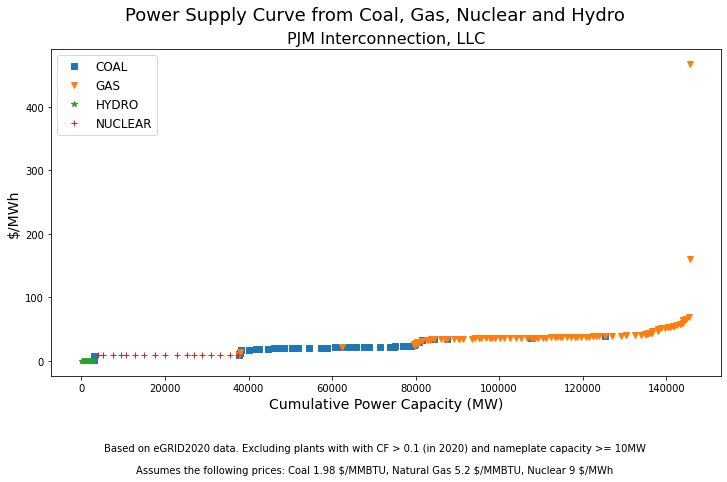

In [ ]:
# 3. Create the supply curve using a scatter plot

# To distinguish the plants by type of fuel we will use different markers
groups = df_plnt_sub.groupby("PLFUELCT")
list_markers = ['s','v','*','+','o']

plt.figure(figsize=(12,6))

#loop to plot each group of plants by type of fuel(different colors and markers)
counter = 0
for name, group in groups:
    plt.plot(group["CUM_CAP"], group["MARG_COST"], marker=list_markers[counter], 
             linestyle="", label=name)
    counter = counter + 1

#Add titles and label axes
plt.suptitle('Power Supply Curve from Coal, Gas, Nuclear and Hydro',
          fontsize=18)
plt.title(BA_NAME, fontsize=16)
plt.xlabel("Cumulative Power Capacity (MW)", fontsize=14)
plt.ylabel("$/MWh",fontsize=14)
plt.legend(fontsize=12)

#Make sure to add a caption that makes this plot a stand-alone piece of information
txt="Based on eGRID2020 data. Excluding plants with with CF > 0.1 (in 2020) and nameplate capacity >= 10MW"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=10)
txt2='Assumes the following prices: Coal {} $/MMBTU, Natural Gas {} $/MMBTU, Nuclear {} $/MWh'.format(AVG_PRICE_COAL, AVG_PRICE_NG, MARG_COST_NUCLEAR,)
plt.figtext(0.5, -0.1, txt2, wrap=True, horizontalalignment='center', fontsize=10)

#Save plot
plt.savefig(path + 'power_supply_curve.png')
plt.show()

# 2. (25%) 
Download year 2022 electricity demand data (bids to buy for the day-ahead market) for PJM from https://dataminer2.pjm.com/feed/hrl_dmd_bids. Make sure you select 1/1/2022 (hour 0:00) as start date and 12/31/2022 (hour 23:59) as end date. 



In [ ]:
#File was manually downloaded and stored in a Gdrive path
#Manage columns with date type information
date_cols = ['datetime_beginning_utc', 'datetime_beginning_ept']
#df_pjm_bids = pd.read_csv(path + 'hrl_dmd_bids.csv', parse_dates=date_cols, 
#                          date_parser=lambda col: pd.to_datetime(col, utc=True))
#open file and parse dates
df_pjm_bids = pd.read_csv(path + 'hrl_dmd_bids.csv', parse_dates=date_cols)

#Select only rows with PJM bids. This could be avoided if data downloaded from
# website was filtered before downloading it
df_pjm_bids = df_pjm_bids.loc[df_pjm_bids.area == 'PJM_RTO']

#Drop columns with area and date in UTC format information. Not needed for this exercise 
df_pjm_bids.drop(columns=['datetime_beginning_utc', 'area'], inplace=True)
df_pjm_bids

,datetime_beginning_ept,hrly_da_demand_bid
2,2022-12-31 23:00:00,72835.0
5,2022-12-31 22:00:00,76891.0
8,2022-12-31 21:00:00,80787.0
11,2022-12-31 20:00:00,82890.0
14,2022-12-31 19:00:00,83720.0
...,...,...
26267,2022-01-01 04:00:00,63761.0
26270,2022-01-01 03:00:00,63771.0
26273,2022-01-01 02:00:00,64830.0
26276,2022-01-01 01:00:00,67228.0


## 2.a (10%) 
Graph the time-series of hourly demand (Include the graph in your word document, with demand in MW in the vertical axis and date in the horizontal axis. Make sure the axes are properly labeled.


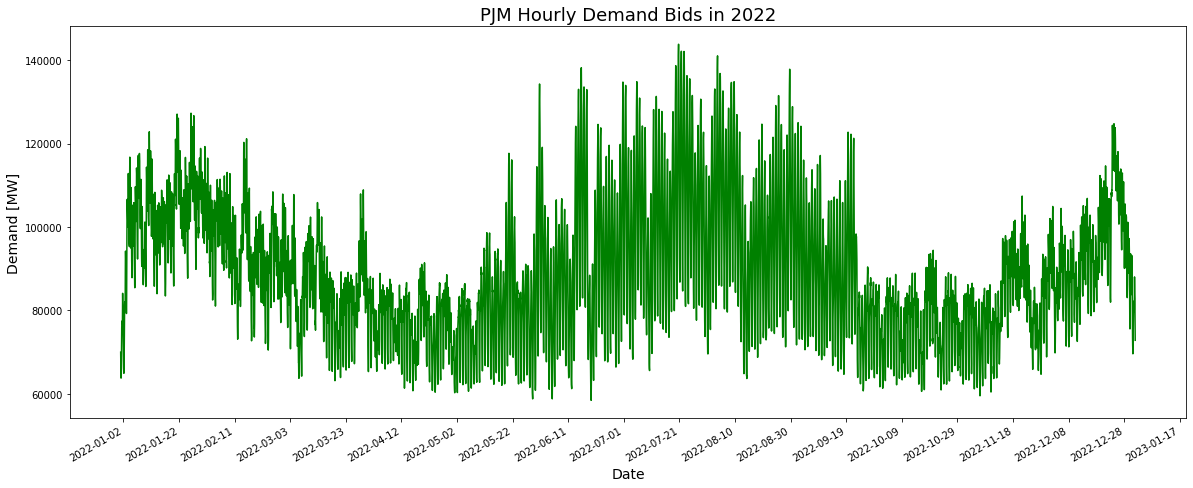

In [ ]:
#libraries used to deal with dates in the plot
import matplotlib.dates as mdates
import datetime as dt

#Configure size of plot
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(8)
#Add title and axis labels
plt.title("PJM Hourly Demand Bids in 2022", size=18)
plt.xlabel('Date', size =14) 
plt.ylabel('Demand [MW]', size =14) 

#Format time axis, arbitrarily selecting 10 days as step for major ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))

#plot time series data
plt.plot(df_pjm_bids.datetime_beginning_ept, df_pjm_bids.hrly_da_demand_bid, color="green")
plt.gcf().autofmt_xdate() #GCF means "get the current figure"

#Save plot
plt.savefig(path + 'pjm_hourly_demand_bids.png')
plt.show()

## 2.b (15%) 
What was the peak demand (in MW) observed in 2022? When did the next 4 highest demands occur in 2022? Fill out the table below.

In [ ]:
print("Peak demand (in MW): ", max(df_pjm_bids.hrly_da_demand_bid))

print("5 highest demands:")
df_pjm_bids.sort_values(by='hrly_da_demand_bid', ascending=False).head(n=5)
#df_pjm_bids.hrly_da_demand_bid


Peak demand (in MW):  143864.0
5 highest demands:


,datetime_beginning_ept,hrly_da_demand_bid
11834,2022-07-20 16:00:00,143864.0
11831,2022-07-20 17:00:00,143819.0
11837,2022-07-20 15:00:00,142681.0
11762,2022-07-21 16:00:00,142190.0
11690,2022-07-22 16:00:00,142138.0


#3. (25%) Clear the market for a few levels of demand.


## 3.a (15%) 
Use the demand data found in 3. to find the percentiles 1, 5, 10, 30, 50, 70, 90, 100 for total annual demand. Write down those percentiles in the table below. If you are using excel, the function Percentile will be useful.  Percentile (Array, 0.9), where array is the matrix containing all the 8760 values of hourly demand in 2019 gives you the percentile 90%. 

Using the supply curve found in 2, find the competitive market-clearing price for different load levels corresponding to each percentile. Use these results to fill out the following table:\\

| Demand/Percentile 	| Demand (MW)  	| **Market Clearing Price ($/MWh)** 	|
|---	|:---:	|:---:	|
| **5%** 	|  	|  	|
| **10%** 	|  	|  	|
| **30%** 	|  	|  	|
| **50%** 	|  	|  	|
| **70%** 	|  	|  	|
| **90%** 	|  	|  	|
| **100%** 	|  	|  	|

In [ ]:
#Demand and maket clearing prices at different percentiles
#values that will be calculated
percentiles =[5, 10, 30, 50, 70, 90, 100]
demands = []
mkt_prices = []
for count, percentile in enumerate(percentiles):
  #using numpy function percentile
  demands.append(np.percentile(df_pjm_bids.hrly_da_demand_bid, percentile))
  #for each demand value, extract the marginal cost of the marginal power unit
  #this means the unit that is able to provide the next MW.
  mkt_prices.append(df_plnt_sub.loc[df_plnt_sub.CUM_CAP >= (demands[count] + 1), 'MARG_COST'].iloc[0])
  print('Demand at perc {}%: {:,.2f} MW, with market clearing price of: {:,.2f} $/MWh'.format(percentile, demands[count], mkt_prices[count]))

Demand at perc 5%: 65,632.85 MW, with market clearing price of: 21.43 $/MWh
Demand at perc 10%: 69,010.10 MW, with market clearing price of: 22.22 $/MWh
Demand at perc 30%: 79,286.10 MW, with market clearing price of: 24.56 $/MWh
Demand at perc 50%: 85,960.50 MW, with market clearing price of: 34.34 $/MWh
Demand at perc 70%: 96,233.80 MW, with market clearing price of: 35.42 $/MWh
Demand at perc 90%: 112,019.30 MW, with market clearing price of: 36.84 $/MWh
Demand at perc 100%: 143,864.00 MW, with market clearing price of: 59.64 $/MWh



As an example of the above calculation, we can see which unit is the marginal unit and its associated marginal cost for the demand at 5% percentile (65,632.85 MW).

With the plants ordered by merit order, in the next table we show the next plants that providing the cumulative capacity above 62,000 MW. Specifically, the plant Brunner Island, LLC will satisfy the demand of the grid between 64,037.9 MW and 65,662.1 MW. So, this plant is the marginal unit for the 5% percentile demand at a market clearing price of $21.43 per MWh.



In [ ]:
df_plnt_sub[df_plnt_sub.CUM_CAP > 62000].head(n=5)

,PNAME,BANAME,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,PLCO2EQA,HEAT_RATE,MARG_COST,CUM_CAP
12571,Mount Storm Power Station,"PJM Interconnection, LLC",COAL,0.32016,1680.9,5.010237e+07,4714228.000,5.181498e+06,10.627905,21.043252,62312.5
9647,Pixelle Specialty Solutions LLC,"PJM Interconnection, LLC",GAS,0.45547,92.8,1.504544e+06,370260.468,0.000000e+00,4.063475,21.130068,62405.3
12567,Mitchell (WV),"PJM Interconnection, LLC",COAL,0.25254,1632.6,3.905257e+07,3611720.000,4.037069e+06,10.812734,21.409213,64037.9
10151,"Brunner Island, LLC","PJM Interconnection, LLC",COAL,0.12933,1624.2,1.991880e+07,1840170.000,1.347141e+06,10.824433,21.432376,65662.1
9522,Cardinal,"PJM Interconnection, LLC",COAL,0.55000,1880.4,9.843259e+07,9059773.000,1.017196e+07,10.864797,21.512298,67542.5


## 3.b (10%) 
Show graphically, how the market is cleared for an inelastic demand (i.e., in the same graph present both the supply curve and the vertical lines for percentiles of demand 5%, 50%, 90% and 100% in the same graph. Their intersection is the price).

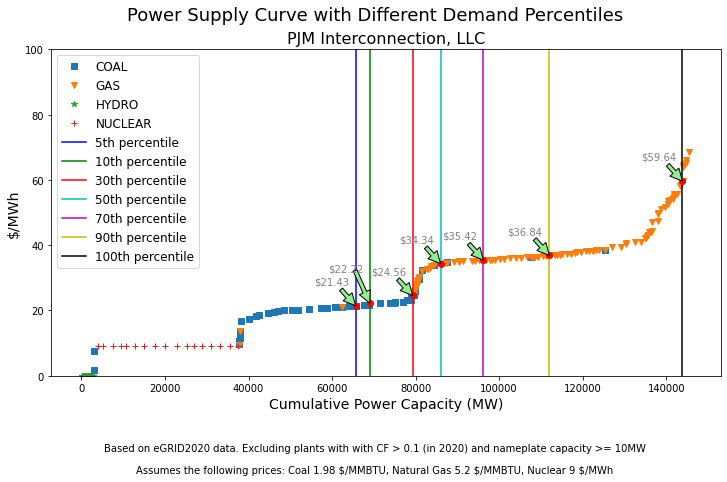

In [ ]:
# Create the supply curve using a scatter plot as done in previous exercise

# To distinguish the plants by type of fuel we will use different markers
groups = df_plnt_sub.groupby("PLFUELCT")
list_markers = ['s','v','*','+','o']

plt.figure(figsize=(12,6))

#loop to plot each group of plants by type of fuel(different colors and markers)
counter = 0
for name, group in groups:
    plt.plot(group["CUM_CAP"], group["MARG_COST"], marker=list_markers[counter], 
             linestyle="", label=name)
    counter = counter + 1

#add demand lines
#use a different color for each line
list_colors= ['b', 'g', 'r','c','m','y', 'k']
#reuse info of percentiles and demands calculated previously
for count, percentile in enumerate(percentiles):
  plt.axvline(x = demands[count], color = list_colors[count], label = '{}th percentile'.format(percentile))
  #Add annotation to show Marketing prices in plot
  shift_y_factor = 1
  py = mkt_prices[count]
  px = demands[count]
  plt.plot(px, py, 'ro')
  if count == 1:
      shift_y_factor = 2
  plt.annotate("", xy=(px, py), xytext=(px-3500,py+5*shift_y_factor),
                           color="green", weight="heavy", fontsize=14,
                           arrowprops={"facecolor": "lightgreen"})
  plt.text(px-10000, py+3*shift_y_factor, "$%0.2f\n"%(py), rotation=0, color='gray')

#Add titles and label axes
plt.suptitle('Power Supply Curve with Different Demand Percentiles',
          fontsize=18)
plt.title(BA_NAME, fontsize=16)
plt.xlabel("Cumulative Power Capacity (MW)", fontsize=14)
plt.ylabel("$/MWh",fontsize=14)
plt.ylim([0,100])
plt.legend(fontsize=12)

#Make sure to add a caption that makes this plot a stand-alone piece of information
txt="Based on eGRID2020 data. Excluding plants with with CF > 0.1 (in 2020) and nameplate capacity >= 10MW"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=10)
txt2='Assumes the following prices: Coal {} $/MMBTU, Natural Gas {} $/MMBTU, Nuclear {} $/MWh'.format(AVG_PRICE_COAL, AVG_PRICE_NG, MARG_COST_NUCLEAR,)
plt.figtext(0.5, -0.1, txt2, wrap=True, horizontalalignment='center', fontsize=10)

#Save plot
plt.savefig(path + 'supply_curve_w_demand.png')
plt.show()


In [ ]:
#access path where workbook is stored
path = "/content/gdrive/MyDrive/ENV717_S23_Solutions/A03/"

pt_iso.to_csv( path + '1b_iso_rto_by_state.csv')  


NameError: ignored

In [ ]:
%%shell
jupyter nbconvert --to html "/content/gdrive/MyDrive/ENV717_S23_Solutions/A03/ENV717_A3_Solution.ipynb"